In [44]:
import warnings
warnings.filterwarnings('ignore')
from pymatch.Matcher import Matcher
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy
import openpyxl
import statsmodels.api as sm

import os
cwd = os.getcwd()
cd = os.chdir('/Users/maryrandriamaro/OneDrive - Washington State University (email.wsu.edu)/wsu/512 econII')

1. Dataset bwght2 to study the effects of expectant mothers smoking while pregnant on the (log) birthweight of their kid.  

In [97]:
file = 'bwght2.csv'
df = pd.read_csv(file)

#handling missing values-data went from 1829 to 1612 (<.5% reduction)
#df.isnull().sum()
bwght_data = df.dropna()

2. Treatment variable, "smoked", will be one if the mother ever smoked

In [98]:
#creating the treatment effect 'smoked': 1 if smokers, else 0
bwght_data['smoked'] = np.where(bwght_data['cigs'] > 0, 1, 0)
bwght_data.head()

,mage,meduc,monpre,npvis,fage,feduc,bwght,omaps,fmaps,cigs,...,mwhte,mblck,moth,fwhte,fblck,foth,lbwght,magesq,npvissq,smoked
0,26,12.0,2.0,12.0,34.0,16.0,3060,9.0,9.0,0.0,...,0,0,1,0,0,1,8.026170,676,144.0,0
2,33,12.0,1.0,12.0,36.0,16.0,2530,8.0,9.0,0.0,...,1,0,0,1,0,0,7.835975,1089,144.0,0
3,28,17.0,5.0,8.0,32.0,17.0,3289,8.0,9.0,0.0,...,1,0,0,1,0,0,8.098339,784,64.0,0
4,23,13.0,2.0,6.0,24.0,16.0,3590,6.0,8.0,0.0,...,1,0,0,1,0,0,8.185907,529,36.0,0
5,28,12.0,1.0,12.0,30.0,16.0,3420,9.0,9.0,0.0,...,1,0,0,1,0,0,8.137396,784,144.0,0


In [109]:
#Average difference in log birthweight of smokers vs. non smokers
smokers = bwght_data.index[bwght_data['smoked'] == 1]
non_smokers = bwght_data.index[bwght_data['smoked'] == 0]
lbwght_smok = bwght_data.loc[smokers,'lbwght']
lbwght_non_smok = bwght_data.loc[non_smokers,'lbwght']
diff_lbwght = lbwght_smok.mean() - lbwght_non_smok.mean()

3. The average difference in log birthweight of smokers vs. non-smokers: -0.06296597224516809

4. Regression of log birthweight on "smoked" controlling for a number of the background variables in the dataset (mage meduc monpre npvis fage feduc fblck magesq npvissq mblck)

In [110]:
#Regression on lbwght
X = bwght_data[['smoked','mage','meduc','monpre','npvis',
'fage','feduc','fblck','magesq','npvissq','mblck']]
y = bwght_data['lbwght']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lbwght   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     4.459
Date:                Wed, 05 Sep 2018   Prob (F-statistic):           1.19e-06
Time:                        17:33:52   Log-Likelihood:                 445.31
No. Observations:                1612   AIC:                            -866.6
Df Residuals:                    1600   BIC:                            -802.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5602      0.140     53.910      0.000       7.285       7.835
smoked        -0.0525      0.017     -3.116      0.002      -0.086      -0.019
mage           0.0249      0.009      2.721      0.007       0.007       0.043
meduc         -0.0015      0.003     -0.523      0.601      -0.007       0.004
monpre         0.0125      0.004      2.913      0.004       0.004       0.021
npvis          0.0121      0.004      3.179      0.002       0.005       0.020
fage           0.0018      0.001      1.548      0.122      -0.000       0.004
feduc          0.0023      0.003      0.911      0.362      -0.003       0.007
fblck          0.0665      0.050      1.327      0.185      -0.032       0.165
magesq        -0.0004      0.000     -2.748      0.006      -0.001      -0.000
npvissq       -0.0002      0.000     -2.018      0.044      -0.000   -6.76e-06
mblck         -0.0619      0.051     -1.212      0.226      -0.162       0.038
==============================================================================
Omnibus:                      795.574   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10828.201
Skew:                          -1.962   Prob(JB):                         0.00
Kurtosis:                      15.075   Cond. No.                     2.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

5. Propensity score matching routine to estimate the average treatment effect

In [133]:
#Estimating ATE from propensity score matching routine
from causalinference import CausalModel

causal_model = CausalModel(
    X=bwght_data[['mage','meduc','monpre','npvis',
'fage','feduc','fblck','magesq','npvissq','mblck']].values,
    D=bwght_data.smoked.values,
    Y=bwght_data.lbwght.values
)
causal_model.est_propensity()
causal_model.trim_s()
causal_model.stratify_s()
causal_model.est_via_matching(bias_adj=True)

print(causal_model.summary_stats)
print(causal_model.estimates)
print(causal_model.propensity)
print(causal_model.strata)


Summary Statistics

                      Controls (N_c=1332)         Treated (N_t=134)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        8.122        0.188        8.060        0.189       -0.062

                      Controls (N_c=1332)         Treated (N_t=134)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       29.415        4.775       28.075        5.298       -0.266
             X1       13.604        2.041       12.567        1.615       -0.564
             X2        2.151        1.233        2.448        1.544        0.212
             X3       11.489        3.611       10.836        4.731       -0.155
             X4       31.798        5.613       30.806        6.646       -0.161
      

.est_via_matching(): estimates average treatment effects using nearest-neighborhood matching.<br>
It matches the treated subjects with subjects that have the similar propensity score but did not receive treatment. Matching is done with replacement.
The unmatched subjects are discarded from the analysis.<br><br>
In this method, the absolute difference between the estimated propensity scores for the control and treatment 
groups is minimized. The control and treatment subjects are randomly ordered. Then the first treated subject is
selected along with a control subject with a propensity score closest in value to it.<br>
$C(P_i)= \min_j \mid P_i - P_j \mid $
where:<br>
$C(P_i)$ represents the group of control subjects $j$ matched to treated
subjects $i$ (on the estimated propensity score)<br>
$P_i$ is the estimated propensity score for the treated subjects $i$ <br>
$P_j$ is the estimated propensity score for the control subjects $j$ <br><br>
$ATE = -0.046$ <br>

6. Treatment on the treated with the propensity score matching routine<br>
$TT = -0.054$ <br>
The difference between the ATE and TT tells us that the treatment assignment is not randomized.<br>
If the treatment was randomized, then $ATE = E(Y_i \mid T_i = 1) - E(Y_i \mid T_i = 0) = E(Y_{1i}) - E(Y_{0i}) = E(Y_i \mid T_i = 1) - E(Y_i \mid T_i = 1) = TT$

7. a) Logit model with "smoked" as the dependent variable

In [112]:
logit_X = bwght_data[['mage','meduc','monpre','npvis',
'fage','feduc','fblck','magesq','npvissq','mblck']]
logit_X = sm.add_constant(logit_X)
logit_Y = bwght_data.smoked
logit = sm.Logit(logit_Y, logit_X).fit(disp=0)
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 smoked   No. Observations:                 1612
Model:                          Logit   Df Residuals:                     1601
Method:                           MLE   Df Model:                           10
Date:                Wed, 05 Sep 2018   Pseudo R-squ.:                 0.08027
Time:                        17:35:08   Log-Likelihood:                -433.30
converged:                       True   LL-Null:                       -471.12
                                        LLR p-value:                 3.575e-12
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1956      2.349      3.064      0.002       2.592      11.799
mage          -0.2917      0.158     -1.849      0.064      -0.601       0.018
meduc         -0.0850      0.055     -1.553      0.120      -0.192       0.022
monpre        -0.0431      0.073     -0.591      0.554      -0.186       0.100
npvis         -0.1775      0.058     -3.075      0.002      -0.291      -0.064
fage           0.0123      0.022      0.565      0.572      -0.030       0.055
feduc         -0.2203      0.049     -4.511      0.000      -0.316      -0.125
fblck          0.1251      0.980      0.128      0.898      -1.795       2.045
magesq         0.0046      0.003      1.716      0.086      -0.001       0.010
npvissq        0.0050      0.002      3.038      0.002       0.002       0.008
mblck         -0.6471      1.041     -0.621      0.534      -2.688       1.394
==============================================================================
"""

7. b) Propensity scores based on the logit model

In [113]:
pscore = pd.DataFrame(logit.predict())
bwght_data['propensity'] = pscore
pscore.head()

,0
0,0.051853
1,0.048044
2,0.029715
3,0.083802
4,0.047410


7. c) Graph of the distributions of the propensity score conditional on "smoked=1" and "smoked=0"

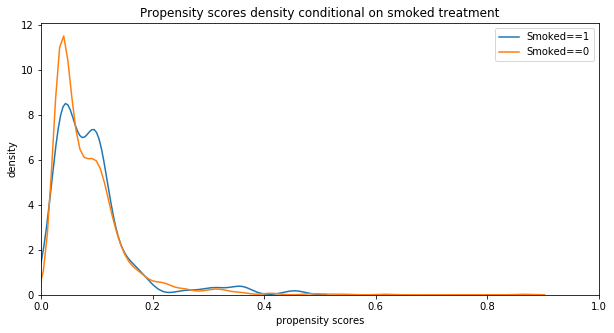

In [131]:
smokers_all = bwght_data.loc[bwght_data['smoked'] == 1]
non_smokers = bwght_data.loc[bwght_data['smoked'] == 0]

ax = sns.kdeplot(smokers_all.propensity, label='Smoked==1')
ax = sns.kdeplot(non_smokers.propensity, label='Smoked==0')
ax.set_xlim(0, 1)
ax.set_title("Propensity scores density conditional on smoked treatment")
ax.set_xlabel("propensity scores")
ax.set_ylabel('density');

There is similarity in the plots of the propensity scores for the treated group (Smoked==1) and the control group (Smoked==0) so the matching routine worked well. 